In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

#dataset: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data
df = pd.read_csv("heart_failure.csv")

In [2]:
df.isnull().sum().reset_index().rename(columns = {0: "count"})

,index,count
0,age,0
1,anaemia,0
2,creatinine_phosphokinase,0
3,diabetes,0
4,ejection_fraction,0
5,high_blood_pressure,0
6,platelets,0
7,serum_creatinine,0
8,serum_sodium,0
9,sex,0


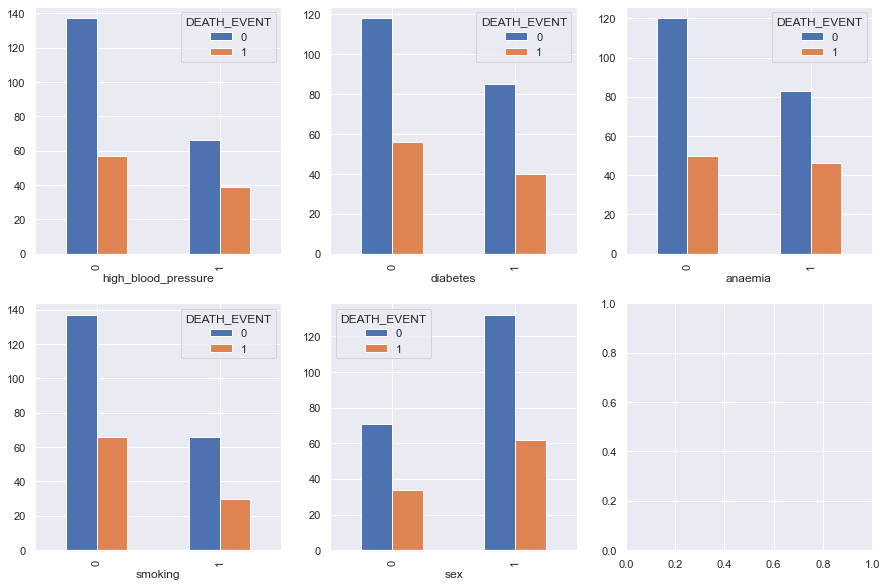

In [3]:
values = [
    ("sex", "DEATH_EVENT"),
    ("smoking", "DEATH_EVENT"),
    ("anaemia", "DEATH_EVENT"),
    ("diabetes", "DEATH_EVENT"),
    ("high_blood_pressure", "DEATH_EVENT")
]

def crosstab_plot(df, values, subplots_nrows, subplots_ncols, figsize):
    fig, axes = plt.subplots(subplots_nrows, 
                             subplots_ncols, 
                             figsize = figsize)
    for row_axes in axes:
        for col_ax in row_axes:
            if len(values) < 1: 
                break
            val = values.pop()
            pd.crosstab(df[val[0]], df[val[1]]).plot.bar(ax = col_ax)
    
crosstab_plot(df, values, 2, 3, (15, 10))

In [4]:
CATEGORICAL_FEATURES = [
    "anaemia",
    "diabetes",
    "high_blood_pressure",
    "sex",
    "smoking"
]

NUM_FEATURES = [
    "age",
    "creatinine_phosphokinase",
    "ejection_fraction",
    "platelets",
    "serum_creatinine",
    "serum_sodium",
    "time"
]

TARGET = "DEATH_EVENT"

In [5]:
from scipy import stats

correlation = []
for nf in NUM_FEATURES:
    corr = stats.pointbiserialr(df[nf], df[TARGET])[0]
    correlation.append((nf, corr))

In [6]:
correlation

[('age', 0.2537285430880036),
 ('creatinine_phosphokinase', 0.06272816025237471),
 ('ejection_fraction', -0.2686033123940619),
 ('platelets', -0.04913886798037428),
 ('serum_creatinine', 0.29427756098414914),
 ('serum_sodium', -0.19520359641640117),
 ('time', -0.526963779277577)]

In [7]:
UNWANTED_COLS = [
    "creatinine_phosphokinase",
    "platelets"
]

In [8]:
import numpy as np

def cramers_v(var1,var2):
    crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
    stat = stats.chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1 
    return (stat / (obs * mini))

In [9]:
correlation = []
for cf in CATEGORICAL_FEATURES:
    corr = cramers_v(df[cf], df[TARGET])
    correlation.append((cf, corr))

In [10]:
correlation

[('anaemia', 0.003485536740090318),
 ('diabetes', 2.8287965007644057e-05),
 ('high_blood_pressure', 0.005162076124738322),
 ('sex', 1.0157554252889576e-05),
 ('smoking', 2.4519978485349505e-05)]

In [11]:
UNWANTED_COLS = UNWANTED_COLS + ["sex", "smoking", "diabetes"]

In [12]:
X = df[CATEGORICAL_FEATURES + NUM_FEATURES].drop(UNWANTED_COLS, axis = 1)
y = df[TARGET]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    stratify = y)

In [14]:
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score

def model_evaluate(X_test, y_test, model):
    pred = model.predict(X_test)
    print("Recall score -> {}".format(recall_score(pred, y_test)))
    print("Accuracy score -> {}".format(accuracy_score(pred, y_test)))
    print("F1 score -> {}".format(f1_score(pred, y_test)))
    print("Precision score -> {}".format(precision_score(pred, y_test)))

model = LGBMClassifier(objective = "binary", random_state = 0)
model.fit(X_train, y_train)
pred = model.predict(X_test)
recall = recall_score(pred, y_test)
accuracy = accuracy_score(pred, y_test)
f1 = accuracy_score(pred, y_test)

model_evaluate(X_test, y_test, model)

Recall score -> 0.7142857142857143
Accuracy score -> 0.7833333333333333
F1 score -> 0.6060606060606061
Precision score -> 0.5263157894736842


In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

classifier = LGBMClassifier(objective = "binary", 
                            random_state = 42)
cv = StratifiedKFold(n_splits = 3)

params = {
    "boosting_type": ["gbdt", "dart"],
    "num_leaves": [4, 5, 10, 15, 20],
    "max_depth": [2, 4, 6, 8, 10],
    "learning_rate": [0.15, 0.1, 0.05, 0.01],
    "n_estimators": [40, 45, 50, 60]
}

scorer = make_scorer(precision_score)
grid = GridSearchCV(estimator = classifier, 
                    param_grid = params, 
                    scoring = scorer, 
                    cv = cv, 
                    n_jobs = -1, verbose = 0)
grid.fit(X_train, y_train)

model_evaluate(X_test, y_test, grid.best_estimator_)

Recall score -> 0.8181818181818182
Accuracy score -> 0.8
F1 score -> 0.6
Precision score -> 0.47368421052631576


In [16]:
model = LGBMClassifier(objective = "binary", random_state = 42, **grid.best_params_)
model.fit(X_train, y_train)

model_evaluate(X_test, y_test, model)

Recall score -> 0.8181818181818182
Accuracy score -> 0.8
F1 score -> 0.6
Precision score -> 0.47368421052631576
